[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

tickers: ['AMZN', 'MSFT', 'AAPL', 'GOOG', 'META', 'ORCL', 'NFLX', 'ADBE', 'TWLO', 'AVGO', 'CRM', 'JNJ', 'LLY', 'PFE', 'UNH', 'V', 'MA', 'BRK-B', 'JPM', 'COST', 'PG']
time window = warmup-date: 2022-04-15, start-date: 2022-08-13, end-data: 2023-08-13



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


2022-08-15, AMZN, close:  143.18,  rsi: 67.02, rsi-ma: 60.81, position: 0.00, pnl-pct: 0.00%
2022-08-15, MSFT, close:  293.47,  rsi: 67.41, rsi-ma: 57.84, position: 0.00, pnl-pct: 0.00%
2022-08-15, AAPL, close:  173.19,  rsi: 75.16, rsi-ma: 64.38, position: 0.00, pnl-pct: 0.00%
2022-08-15, GOOG, close:  122.88,  rsi: 63.22, rsi-ma: 54.06, position: 0.00, pnl-pct: 0.00%
2022-08-15, META, close:  180.89,  rsi: 59.21, rsi-ma: 50.03, position: 0.00, pnl-pct: 0.00%
2022-08-15, ORCL, close:   79.11,  rsi: 67.49, rsi-ma: 60.35, position: 0.00, pnl-pct: 0.00%
2022-08-15, NFLX, close:  249.11,  rsi: 70.63, rsi-ma: 60.54, position: 0.00, pnl-pct: 0.00%
2022-08-15, ADBE, close:  451.02,  rsi: 69.62, rsi-ma: 58.62, position: 0.00, pnl-pct: 0.00%
2022-08-15, TWLO, close:   87.46,  rsi: 49.23, rsi-ma: 47.40, position: 0.00, pnl-pct: 0.00%
2022-08-15, AVGO, close:   55.90,  rsi: 64.09, rsi-ma: 56.18, position: 0.00, pnl-pct: 0.00%
2022-08-15, CRM, close:  191.06,  rsi: 59.31, rsi-ma: 55.37, position:

<IPython.core.display.Javascript object>

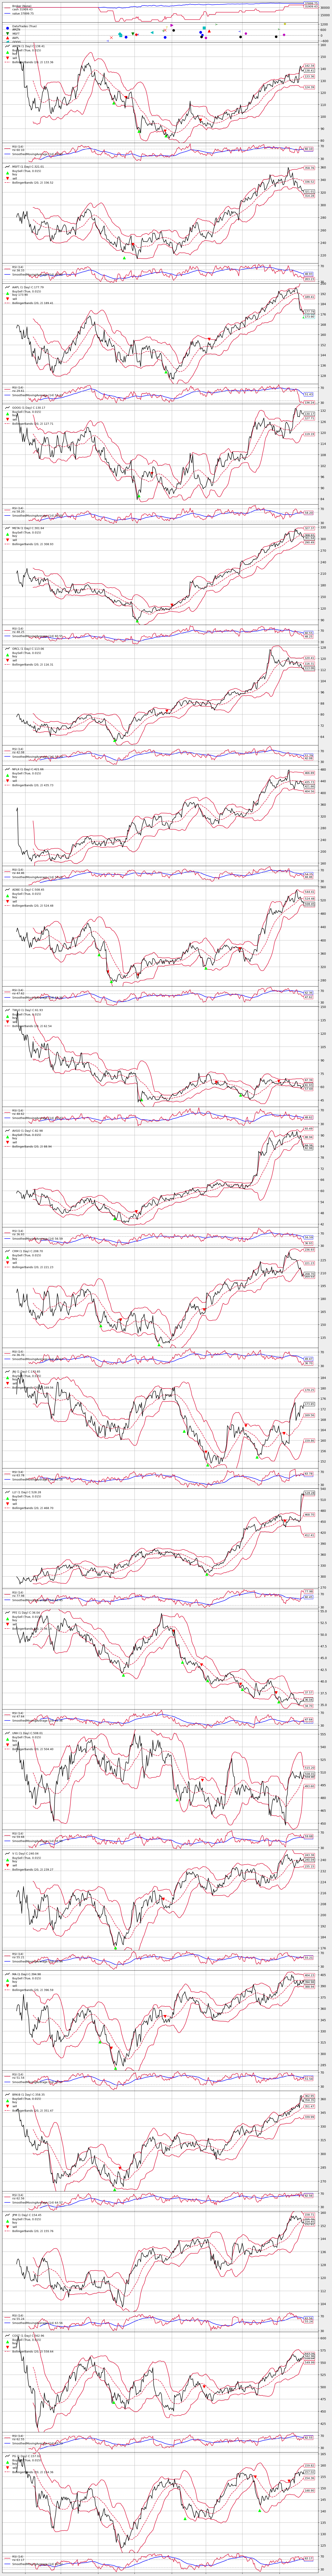

In [9]:
import conf

from services.backtesting_service import RsiBollingerStrategy
from optimise_common import *

import datetime  # For datetime objects
import backtrader as bt
import backtrader.analyzers as btanalyzers
import yfinance as yf

optimise = False
initial_cash = 30000

# strategy-controls
printlog=True
upper_rsi=60
lower_rsi=35
loss_pct_threshold = 8
profit_protection_pct_threshold = 0
fixed_investment_amount=3000 
# backtest window 
num_years = 1
year_offset = 0

# stock to test
#tickers = non_tech_stock
tickers = interesting_stock
#tickers = ['NFLX', 'JPM', 'AMZN', 'BRK-B', 'UNH', 'PFE']

warmup_date, start_date, end_date = optimisation_dates(num_years, year_offset)

def add_stats(rsi_lower, rsi_upper, loss_pct, profit_protection_pct_threshold, fixed_investment_amount, final_value):
    stats.append({'rsi_lower': rsi_lower, 
                  'rsi_upper': rsi_upper, 
                  'loss_pct': loss_pct,
                  'profit_protection_pct_threshold': profit_protection_pct_threshold,
                  'fixed_investment_amount': fixed_investment_amount ,
                  'final_value': final_value}) 

def pnl_report(strategy):
    total_pnl = 0
    # Unwind any open opositions
    for ticker in strategy.stock_pnl.keys():
        if strategy.getpositionbyname(ticker):
            position = strategy.getpositionbyname(ticker)
            data = strategy.getdatabyname(ticker)
            open_pnl = ((position.size * data.close[0])-(position.size*position.price))
            #print(f'{ticker} open PNL: {position.size:2f} x {data.close[0]:2f} - {position.size:2f} x {position.price:2f} = {open_pnl:2f}')
            strategy.stock_pnl[ticker] += open_pnl
    for ticker in strategy.stock_pnl.keys():
        print(f'{ticker} PNL: {strategy.stock_pnl[ticker]:.2f}')
        total_pnl += strategy.stock_pnl[ticker]
    print(f'Total PNL: {total_pnl:.2f}')

def strategy_completed_callback(strategy):
    final_value = strategy.broker.get_value()
    print("strategy_completed_callback stats: " + 
        f'lower_rsi: {strategy.params.lower_rsi}, ' +
        f'upper_rsi: {strategy.params.upper_rsi}, ' +
        f'loss_pct: {strategy.params.loss_pct_threshold}, ' +
        f'profit_protection_pct_threshold: {strategy.params.profit_protection_pct_threshold}, ' +
        f'fixed_investment_amount: {strategy.params.fixed_investment_amount}, ' +
        f'final Portfolio Value: {final_value:.0f}'
    )
    stats.append({'rsi_lower': strategy.params.lower_rsi, 
        'rsi_upper': strategy.params.upper_rsi, 
        'loss_pct': strategy.params.loss_pct_threshold,
        'profit_protection_pct_threshold': strategy.params.profit_protection_pct_threshold,
        'fixed_investment_amount': strategy.params.fixed_investment_amount,
        'final_value': round(strategy.broker.getvalue())}) 

stats = []

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = create_cerebro()

    if not optimise:
        # Add a strategy (see strategy-controls)
        cerebro.addstrategy(RsiBollingerStrategy,
                            start_date = start_date,
                            printlog = printlog,
                            upper_rsi = upper_rsi,
                            lower_rsi = lower_rsi,
                            loss_pct_threshold = loss_pct_threshold,
                            profit_protection_pct_threshold = profit_protection_pct_threshold,
                            fixed_investment_amount = fixed_investment_amount,
                            custom_callback=pnl_report)
    else:
        strats = cerebro.optstrategy(
            RsiBollingerStrategy,
            start_date = start_date,
            upper_rsi= 60 , # upper_rsi=range(55, 70, 5), RSI-upper down-crossing not wired
            lower_rsi = range(30, 60, 5), #, 40 
            loss_pct_threshold = 8, # range(1,15),
            profit_protection_pct_threshold = 0, #range(0, 100, 25),
            fixed_investment_amount = 5000, # range(500, 5500, 500),
            custom_callback=strategy_completed_callback,
            )
        cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

    add_data_feed(cerebro, tickers, warmup_date, start_date, end_date)
    set_cash(cerebro, initial_cash)
    
    execute_cerebro(cerebro, optimise, stats)

    
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams #Creates parameters for our plot
if not optimise:
    print(f'Plotting graphs ...')
    # Plot the result
    rcParams['figure.figsize'] = 16, 6 * len(tickers) #size
    rcParams['figure.facecolor'] = '#eeeeee' #Color scheme
    plt.plot() #The Plot Code
    plt.close()
    cerebro.plot(iplot=True, volume=False)
 